## Get Data

In [21]:
import pandas as pd
import pickle

# convert back
data = pd.read_pickle('vars/data.pkl')
with open('vars/avg_dicts.pkl', 'rb') as f:
    avg_dicts = pickle.load(f)
with open('vars/profile_dicts.pkl', 'rb') as f:
    profile_dicts = pickle.load(f)
with open('vars/timing_dicts.pkl', 'rb') as f:
    timing_dicts = pickle.load(f)

In [22]:
def setBoxColors(bp):
    plt.setp(bp['boxes'][0], color='red')
    plt.setp(bp['caps'][0], color='red')
    plt.setp(bp['caps'][1], color='red')
    plt.setp(bp['whiskers'][0], color='red')
    plt.setp(bp['whiskers'][1], color='red')
    plt.setp(bp['medians'][0], color='red')

    plt.setp(bp['boxes'][1], color='blue')
    plt.setp(bp['caps'][2], color='blue')
    plt.setp(bp['caps'][3], color='blue')
    plt.setp(bp['whiskers'][2], color='blue')
    plt.setp(bp['whiskers'][3], color='blue')
    plt.setp(bp['medians'][1], color='blue')


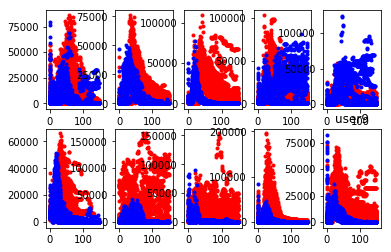

In [23]:
names = ["user"+str(i) for i in range(10)]
fig, ax = plt.subplots(2,5)
for idx, name in enumerate(names):
    i = idx // 5
    j = idx % 5 
    ax[i,j].scatter(*zip(*(timing_dicts[0][0][name])), marker='.', c='r')
    ax[i,j].scatter(*zip(*(timing_dicts[0][1][name])), marker='.', c='b')
    plt.title(name)
    # plt.legend(['hard', 'soft'])
plt.show()

## General Preprocessing

In [24]:
from sklearn.preprocessing import LabelEncoder

# encode categorical variables
le = LabelEncoder()
data['pressure'] = le.fit_transform(data.pressure)
data['name'] = le.fit_transform(data.name)
data.head()

,name,pressure,material,length,angle,deviation,avg,max,avgbin0,avgbin1,...,timebin0,timebin1,timebin2,timebin3,timebin4,timebin5,timebin6,timebin7,timebin8,timebin9
0,0,0,cloth,104.449376,-0.175550,1.000001,19.231282,1045.0,2841.0,17469.0,...,122148,18102,200172,526818,178356,23883,1566,81,81,51657
1,0,0,cloth,155.760767,-0.264559,1.000106,24.743583,1099.0,11174.0,72605.0,...,62193,164496,619635,753174,253248,38580,0,0,0,16920
2,0,0,cloth,171.779950,-0.156122,1.001261,27.672589,1552.0,6910.0,58674.0,...,43293,16782,102648,494235,687510,577845,199650,47640,9999,567
3,0,0,cloth,173.595691,-0.417076,1.017135,11.388188,824.0,18099.0,23786.0,...,29376,35163,160212,278133,246987,143826,19206,1065,1065,1770
4,0,0,cloth,142.646926,-0.326745,1.001766,16.211146,889.0,2889.0,22909.0,...,25992,147,3396,37257,27240,237210,409527,226086,85698,35904


## Feature Selection

Definitely include average and max pixel intensity.

In [489]:
data[['pressure', 'avg', 'max']].groupby("pressure").describe().T

pressure             0            1
avg count   233.000000   234.000000
    mean     47.883421    14.906541
    std      28.977565    10.747680
    min       0.791754     0.066964
    25%      28.448096     6.431245
    50%      42.525277    11.204904
    75%      61.012162    22.370643
    max     156.303030    53.357670
max count   233.000000   234.000000
    mean   3330.579399  1379.196581
    std    1603.049213   860.005312
    min     135.000000     6.000000
    25%    2267.000000   794.000000
    50%    3411.000000  1167.000000
    75%    4281.000000  1792.500000
    max    7920.000000  5642.000000

In [169]:
data[['pressure', 'total_time']].astype(int).groupby("pressure").describe().T

pressure                   0           1
total_time count  233.000000  234.000000
           mean   148.540773  138.773504
           std      7.853141   23.014363
           min     57.000000   19.000000
           25%    150.000000  143.000000
           50%    150.000000  148.000000
           75%    150.000000  150.000000
           max    150.000000  150.000000

Histogram data appears to be useful as well, but it may be best to combine all of these into a single metric.

/home/dunntj/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


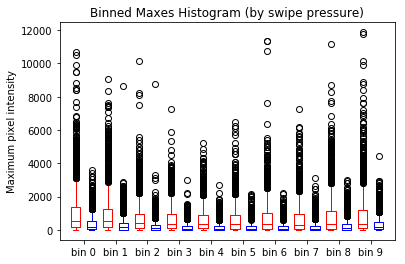

In [25]:
# plot histograms
fig = plt.figure()
ax = plt.axes()
for i in range(N_BINS):
    bp = plt.boxplot([data[data["pressure"]==0]["maxbin"+str(i)], 
                  data[data["pressure"]==1]['maxbin'+str(i)]],
                  positions=[2*i, 2*i+1],
                  widths=0.6)
    setBoxColors(bp)
plt.xlim(-1, N_BINS*2)
plt.title("Binned Maxes Histogram (by swipe pressure)")
ax.set_xticklabels(["bin "+str(i) for i in range(N_BINS)])
ax.set_xticks(np.arange(0.5, N_BINS*2+0.5, 2))
plt.ylabel("Maximum pixel intensity")
plt.show()

In [12]:
data['pressure'].value_counts()

1    234
0    233
Name: pressure, dtype: int64

In [13]:
# define feature columns
feature_cols = [x for x in data.columns if "bin" in x] + ["avg", "max", "total_time"]

### SVM Preprocessing

In [26]:
from sklearn.preprocessing import StandardScaler

# columns should have zero mean and unit variance
ss = StandardScaler()
data[feature_cols] = ss.fit_transform(data[feature_cols])
data.head()

/home/dunntj/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/dunntj/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,name,pressure,material,length,angle,deviation,avg,max,avgbin0,avgbin1,...,timebin0,timebin1,timebin2,timebin3,timebin4,timebin5,timebin6,timebin7,timebin8,timebin9
0,0,0,cloth,104.449376,-0.175550,1.000001,0.228359,-0.235561,-0.661478,-0.459107,...,0.024882,-0.834324,-0.261531,0.890504,-0.159731,-0.631232,-0.665145,-0.645642,-0.614235,-0.407977
1,0,0,cloth,155.760767,-0.264559,1.000106,0.520098,-0.202405,-0.524355,0.328475,...,-0.372045,-0.300902,1.065341,1.623691,0.090316,-0.581955,-0.670344,-0.645915,-0.614515,-0.545975
2,0,0,cloth,171.779950,-0.156122,1.001261,0.675116,0.075739,-0.594521,0.129479,...,-0.497171,-0.839134,-0.570026,0.784964,1.540217,1.226134,-0.007497,-0.485247,-0.579986,-0.610939
3,0,0,cloth,173.595691,-0.417076,1.017135,-0.186737,-0.371256,-0.410401,-0.368873,...,-0.589307,-0.772158,-0.387935,0.084990,0.069412,-0.229078,-0.606579,-0.642323,-0.610837,-0.606160
4,0,0,cloth,142.646926,-0.326745,1.001766,0.068518,-0.331346,-0.660688,-0.381400,...,-0.611711,-0.899748,-0.883986,-0.695229,-0.664273,0.084027,0.689303,0.116568,-0.318575,-0.470558


### Random Forest Preprocessing
None

### Neural Network Preprocessing

In [15]:
from sklearn.preprocessing import StandardScaler

# columns should have zero mean and unit variance
ss = StandardScaler()
data[feature_cols] = ss.fit_transform(data[feature_cols])
data.head()

,name,pressure,length,angle,deviation,avg,max,avgbin0,avgbin1,avgbin2,...,timebin0,timebin1,timebin2,timebin3,timebin4,timebin5,timebin6,timebin7,timebin8,timebin9
0,0,0,127.637485,-0.626405,1.002858,-0.580806,-0.564493,-0.307677,-0.332681,-0.444010,...,-0.683539,0.242655,-0.500393,-0.765534,-0.928286,-0.909198,-0.920175,-0.886935,-0.818963,-0.637271
1,0,0,127.890571,0.548046,1.000008,1.124113,0.198672,0.390540,1.176970,1.531494,...,-0.908557,0.481780,0.746135,0.670953,0.647007,0.608051,0.443709,0.569801,0.461396,0.547736
2,0,0,133.577269,-0.441437,1.000168,0.859915,0.424519,-0.543547,0.315261,1.150351,...,-0.977251,0.813885,1.347124,0.866564,0.626324,0.207389,-0.116643,-0.098123,-0.315966,-0.795800
3,0,0,134.448610,-0.646169,1.429822,0.244349,0.767012,-0.729793,1.578904,1.284429,...,-0.743778,0.228365,0.355025,0.315638,0.292955,0.345261,0.233795,0.004207,-0.096049,-0.074370
4,0,0,133.327134,0.653112,1.514587,-0.107373,0.283054,-0.498851,1.314162,0.692515,...,-0.968673,-0.216550,-0.210841,0.275062,0.276676,-0.135590,-0.231208,-0.269602,-0.203652,-0.345021


## Partition Data for Training and Testing

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
train_idx, test_idx = next(sss.split(data[feature_cols], data.name))

X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'pressure']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'pressure']

X_train.head()

,avgbin0,avgbin1,avgbin2,avgbin3,avgbin4,avgbin5,avgbin6,avgbin7,avgbin8,avgbin9,...,timebin3,timebin4,timebin5,timebin6,timebin7,timebin8,timebin9,avg,max,total_time
1659,-0.471846,-0.534557,-0.493071,-0.482255,-0.418602,-0.422037,-0.379498,-0.279762,-0.211095,-0.162123,...,-0.746030,-0.751795,-0.707869,-0.666937,-0.642485,-0.610972,-0.578487,-0.452687,-0.184599,0.463127
572,0.242698,1.209605,0.811174,-0.344724,-0.442198,-0.106679,0.513594,1.067831,1.037471,0.374259,...,-0.056959,-0.130223,-0.056543,-0.012378,-0.148240,-0.291856,-0.144996,1.274744,-0.051360,0.463127
11,-0.580452,-0.218730,-0.006652,0.008573,0.169784,0.205615,0.127942,0.012902,0.720975,-0.067493,...,-0.145581,-0.388654,-0.630347,-0.669896,-0.645460,-0.614049,-0.586925,0.579474,0.216346,0.433776
906,-0.210435,-0.708641,-0.671142,-0.105619,-0.618084,-0.572338,-0.562107,-0.146501,-0.583846,-0.644776,...,-0.690846,-0.546010,-0.396353,-0.435364,-0.418623,-0.500960,-0.525440,-0.676828,-0.551774,0.404426
2794,1.741935,0.431494,-0.144221,-0.420125,-0.440826,-0.388526,-0.243749,-0.044838,-0.002328,0.507674,...,-0.287132,-0.481615,-0.541188,-0.576400,-0.589863,-0.586264,-0.551946,-0.051709,1.588645,0.463127


### Compute Additional Features

In [146]:
## compute hard/soft binned max similarity metrics
#hbms = pd.Series(np.zeros(X_train.shape[0]))
#sbms = pd.Series(np.zeros(X_train.shape[0]))
#
#for i in range(N_BINS):
#    # find mean per bin 
#    mean_hardmax = X_train[y_train==0]["maxbin"+str(i)].mean()
#    mean_softmax = X_train[y_train==1]["maxbin"+str(i)].mean()
#    
#    # new feature is sum of differences from mean
#    hbms += np.abs(X_train["maxbin"+str(i)].values - mean_hardmax)
#    sbms += np.abs(X_train["maxbin"+str(i)].values - mean_softmax)
#    
#hbms.index = X_train.index
#sbms.index = X_train.index
#X_train['hbms'] = hbms
#X_train['sbms'] = sbms

### Linear Support Vector Machine
80-85% success rate

In [8]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

lsvc = LinearSVC().fit(X_train, y_train)
y_pred = lsvc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

### Support Vector Machine
85-90% success rate

In [198]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

svc = SVC().fit(X_train, y_train)
y_pred = svc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

### Random Forest
90-95% success rate

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rfc = RandomForestClassifier(n_estimators = 500, max_features=6)
rfc = rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

### Neural Network
80-85% success rate

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

param_grid = [
    {'alpha': 10.0**-np.arange(1,7),
    'hidden_layer_sizes': [(6,4), (4,6,3), (10,7,4)]}
]
nnc = MLPClassifier(solver='lbfgs')
nnc = GridSearchCV(nnc, param_grid, cv=5)
nnc.fit(X_train, y_train)
y_pred = nnc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

## Show Results

accuracy: 82.79%


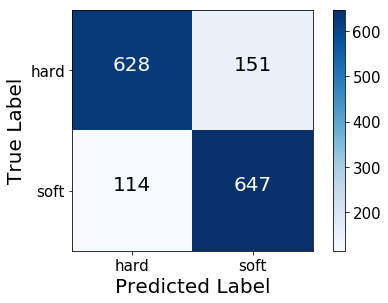

In [29]:
import itertools
% matplotlib inline

plt.imshow(cm, interpolation='nearest', cmap='Blues')
#plt.title('Confusion Matrix for Swipe Classification')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15) 
pressures = ['hard', 'soft']
tick_marks = np.arange(len(pressures));
plt.xticks(tick_marks, pressures, fontsize=15);
plt.yticks(tick_marks, pressures, fontsize=15);

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 fontsize=20,
                 color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.xlabel('Predicted Label', fontsize=20);
plt.ylabel('True Label', fontsize=20);
print("accuracy: {0:.2f}%".format(100*(cm[0,0]+cm[1,1]) / cm.sum()))